In [1]:
'''
To Do:
1. (DONE) Reshape forward function under model class into 299 * 299 * 3
  Use layers in inception v3 (https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py)
    or pytorch (https://pytorch.org/docs/stable/nn.html) 
2. Superimpose image after training
3. Look for other functions instead of resizing into 299 * 299

Problems:
1. Need to rerun every try (string concatenation)

Questions:
'''

'\nTo Do:\n1. (DONE) Reshape forward function under model class into 299 * 299 * 3\n  Use layers in inception v3 (https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py)\n    or pytorch (https://pytorch.org/docs/stable/nn.html) \n2. Superimpose image after training\n\nProblems:\n1. Need to rerun every try (string concatenation)\n\nQuestions:\n1. Why dimensions not the same as calculation\n2. Stride and kernal size meaning\n3. Does it need to be hardcoding input/output channel values? \n4. Does model.eval() train the model already? (bottom block)\n'

In [2]:
import keras
import tensorflow as tf
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
from tqdm import tqdm
from torchvision.models.inception import Inception3
import numpy as np
import matplotlib.pyplot as plt

In [14]:
from IPython.core.display import Image
from PIL import Image
import os

path = "/content/drive/MyDrive/VIP/data_road/"
train_path = path + "training/"
test_path = path + "testing/"

train_data = os.listdir(train_path + "image_2")
train_label = os.listdir(train_path + "gt_image_2")
test_data = os.listdir(test_path + "image_2")

class dataset(Dataset):
  def __init__(self,test=False,transf=transforms.ToTensor()):
    super().__init__()
    self.test=test
    self.trans = transf
    if test:
      self.data = test_data
    else:
      self.data = train_data
      self.labels = train_label

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
    if self.test:
      data_name = self.data[idx]
      data = Image.open(test_path + "image_2/" + data_name)
      data = data.resize((299, 299)) # Change later
      return self.trans(data), 0
    else:
      data_name = self.data[idx]
      label_name = self.labels[idx]
      data = Image.open(train_path + "image_2/" + data_name)
      #print(data.shape)
      label = Image.open(train_path + "gt_image_2/" + label_name)
      data = data.resize((299, 299)) # Change later
      label = label.resize((299, 299)) # Change later
      return self.trans(data), self.trans(label)

In [4]:
def train_model(model, data_loader, loss, optimizer, epochs):
  device=torch.device('cuda:0')
  model.to(device)
  model.train()
  loss_list=[]
  b_list=[]
  for epoch in range(epochs):
    print("Epoch: ", epoch)
    model.train()
    for data, label in tqdm(train_data_load):
      #data=data.reshape(-1,1242 * 375 * 3) #-1 --> flatten into single vector
      data=data.to(device)
      label = label.to(device)
      output=model(data)
      batch_loss=loss(output, label)
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      b_list.append(batch_loss.cpu().detach().numpy())
    loss_list.append(sum(b_list)/len(b_list))
  return loss_list

In [5]:
class model(nn.Module):
  def __init__(self):
    super().__init__()
    #self.layer1=nn.Linear(768 * 17 * 17, 299 * 299 * 3)
    self.layer2=torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
    self.MaxPool2b=nn.MaxPool2d(3,2)
    self.AvgPool=nn.AdaptiveAvgPool2d((1,1))
    self.Upsample=nn.Upsample(scale_factor=(1.17,1.035)) 

    self.t_layer1=nn.ConvTranspose2d(768,256,kernel_size=3,stride=5)
    self.t_layer2=nn.ConvTranspose2d(256,64,3,5)
    self.t_layer3=nn.Conv2d(64,32,3,3)
    self.t_layer4=nn.ConvTranspose2d(32,16,3,5)
    self.t_layer5=nn.Conv2d(16,3,3,2)
    self.t_layer6=nn.Conv2d(3,3,3)
    #self.t_layer6=nn.Conv2d(3,3,3)
    


  def forward(self,x):
    #x=self.layer1(x)
    if self.layer2.transform_input:
        x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
    # N x 3 x 299 x 299
    x = self.layer2.Conv2d_1a_3x3(x)
    # N x 32 x 149 x 149
    x = self.layer2.Conv2d_2a_3x3(x)
    # N x 32 x 147 x 147
    x = self.layer2.Conv2d_2b_3x3(x)
    # N x 64 x 147 x 147
    x = self.MaxPool2b(x)
    # N x 64 x 73 x 73
    x = self.layer2.Conv2d_3b_1x1(x)
    # N x 80 x 73 x 73
    x = self.layer2.Conv2d_4a_3x3(x)
    # N x 192 x 71 x 71
    x = self.MaxPool2b(x)
    # N x 192 x 35 x 35
    x = self.layer2.Mixed_5b(x)
    # N x 256 x 35 x 35
    x = self.layer2.Mixed_5c(x)
    # N x 288 x 35 x 35
    x = self.layer2.Mixed_5d(x)
    # N x 288 x 35 x 35
    x = self.layer2.Mixed_6a(x)
    # N x 768 x 17 x 17
    x = self.layer2.Mixed_6b(x)
    # N x 768 x 17 x 17
    x = self.layer2.Mixed_6c(x)
    # N x 768 x 17 x 17
    x = self.layer2.Mixed_6d(x)
    # N x 768 x 17 x 17
    x = self.layer2.Mixed_6e(x)
    
    #print(x.shape)

    # N x 256 x 85 x 85
    x=self.t_layer1(x)
    # N x 64 x 425 x 425 (why 64, 413, 413)
    x=self.t_layer2(x)
    # N x 32 x 141 x 141 (why 16, 137, 137)
    x=self.t_layer3(x)
    # N x 32 x 705 x 705 (4, 683, 683)
    x=self.t_layer4(x)
    # (3, 341, 341)
    x=self.t_layer5(x)
    # (3, 299, 299)
    for i in range(21):
      x=self.t_layer6(x)

    return x

'''
    # N x 768 x 17 x 17
    #aux_defined = self.layer2.training and self.layer2.aux_logits
    #if aux_defined:
    #    aux = self.layer2.AuxLogits(x)
    #else:
    #    aux = None

    # N x 768 x 17 x 17
    #x=self.Upsample(x)
    x=torch.reshape(x,(-1,3,256,289))    
    print(x.shape)
    #Upsample here
    #x=self.layer2.fc(x)
    x=self.Upsample(x) 
    #print(x.shape) Verify dimension
    print(x.shape,"\n")
    return x
'''

model=model()
loss=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters())

train_data=dataset()
#train_data.__getitem__(0)

train_data_load=DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)

#for data, label in train_data_load:
#  print(data)

loss_list=train_model(model, train_data_load, loss, optimizer, epochs=50)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch:  0


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch:  1


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch:  2


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch:  3


100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch:  4


100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Epoch:  5


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  6


100%|██████████| 18/18 [00:19<00:00,  1.11s/it]


Epoch:  7


100%|██████████| 18/18 [00:24<00:00,  1.36s/it]


Epoch:  8


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch:  9


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  10


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  11


100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Epoch:  12


100%|██████████| 18/18 [00:19<00:00,  1.11s/it]


Epoch:  13


100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Epoch:  14


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  15


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  16


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch:  17


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch:  18


100%|██████████| 18/18 [00:19<00:00,  1.11s/it]


Epoch:  19


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


Epoch:  20


100%|██████████| 18/18 [00:20<00:00,  1.11s/it]


Epoch:  21


100%|██████████| 18/18 [00:20<00:00,  1.11s/it]


Epoch:  22


100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


Epoch:  23


100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Epoch:  24


100%|██████████| 18/18 [00:23<00:00,  1.30s/it]


Epoch:  25


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch:  26


100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


Epoch:  27


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch:  28


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch:  29


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch:  30


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch:  31


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch:  32


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


Epoch:  33


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch:  34


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch:  35


100%|██████████| 18/18 [00:27<00:00,  1.52s/it]


Epoch:  36


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch:  37


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


Epoch:  38


100%|██████████| 18/18 [00:31<00:00,  1.74s/it]


Epoch:  39


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  40


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch:  41


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  42


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  43


100%|██████████| 18/18 [00:24<00:00,  1.37s/it]


Epoch:  44


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch:  45


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  46


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  47


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch:  48


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch:  49


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


In [15]:
model.eval()

test_data=dataset(test=True)
test_data_loader=DataLoader(test_data, batch_size=16, shuffle=True)

for data, _ in test_data_loader:
  device=torch.device('cuda:0')
  #data=data.reshape(-1, 1242 * 375 * 3)
  data=data.to(device)
  predictions=model(data)
  break

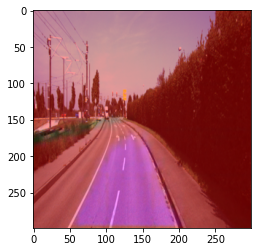

In [22]:
# display reconstruction
#ax = plt.subplot(3, n, i + 1 + n + n)
#np.moveaxis(predictions[0], 0, -1).shape # Changing image format from 3 * 299 * 299 into 299 * 299 * 3
pred=predictions[2].permute(1,2,0)

plt.imshow(pred.cpu().detach().numpy())
#plt.gray()
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
#plt.show()

test_img=data[2].permute(1,2,0)
plt.imshow(test_img.cpu().detach().numpy(), alpha = 0.6)
plt.show()